# PyGPlates Tutorial - reconstructing a set of features to their 'birth' time

This tutorial goes through some examples of how to use pygplates to reconstruct feature collections, using the age properties of each feature to determine the time to reconstruct each feature to.

The process is demonstrated by reproducing results of two previous studies where the ; the reconstruction of Large Igneous Provinces to their birth time and the relationship of these locations to deep Earth structure (e.g. Burke and Torsvik, 2006) and the migration of Mid-Ocean Ridge locations through time (Whittaker et al, 2015).

These examples demonstrate how pygplates complements the GPlates GUI, by using the same files and reconstruction engine, but allowing us to visualise spatio-temporal data in a way that GPlates GUI does not allow - we can quickly create visualisations that show spatio-temporal patterns through time, rather than only looking at one timeslice at a time.

First, we load in the necessary python modules, and load in the default GPlates rotation model

In [18]:
import pygplates
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# load in a rotation model - note, this only needs to be done once, then the model is in memory and is available 
# throughout the rest of the script
rotation_filename = 'Data/Seton_etal_ESR2012_2012.1.rot'
rotation_model=pygplates.RotationModel(rotation_filename)


[NB The pygplates-code-snippets tutorial contains some simpler examples that relate to individual elements of the next cell]

Next, we are going to generate some reconstructed locations of Large Igneous Provinces (LIPs). 

But first.....

Before actually executing the next cell, you may find it usefule to load the data we are going to use into GPlates GUI (for example, load in the LIPs file, the rotation file, and a coastline file). By loading and reconstructing these data in GPlates, it will help you to follow what the next section of code does. 

The LIP file contains a collection of polygons distributed across the Earth. Each polygon has an 'appearance' time that corresponds to the time that LIP formed, and a plateid that allows us to reconstruct each LIP. 

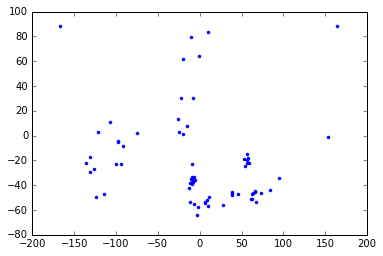

In [19]:
# Get the features from the LIPs file
LIP_File = "Data/LIPs_2014.gpmlz"
features = pygplates.FeatureCollection(LIP_File)

# Create empty arrays to which we will append the reconstructed coordinates and age for each LIP
Xr = []
Yr = []
Age = []

for feature in features:
    
    # NB valid_time is a tuple, we take the first value since this is the 'birth' time of the LIP
    BirthTime = feature.get_valid_time()[0]   
    PlateID = feature.get_reconstruction_plate_id()
    
    # Reconstruct each observation data point back to 0Ma relative to proposed Africa location
    # Convert data lat lon to point on sphere
    LIP_Polygon = feature.get_geometry()

    # Get rotation for data point and reconstruct to 0Ma
    LIP_rotation = rotation_model.get_rotation(BirthTime, PlateID, anchor_plate_id=1)
    
    # Here, we have an option to exclude LIPs with an area smaller than some threshold value
    # The values must be specified in terms of the area of a unit sphere, hence a value in km^2
    # must be divided by Earth_Radius squared
    if LIP_Polygon.get_area() > 20000./(6371.**2):
        reconstructed_point = LIP_rotation * LIP_Polygon.get_boundary_centroid()
        reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()

        Xr.append(reconstructed_point_degrees.get_longitude())
        Yr.append(reconstructed_point_degrees.get_latitude())
        Age.append(BirthTime)

        
# A quick and dirty plot, just to check that we have some reconstructed points
plt.plot(Xr,Yr,'.')
plt.show()


### Plotting

One hypothesis to explain the occurance of LIPs is that their distribution is correlated with deep mantle structure, as imaged by seismic tomography.

Note the code below is borrowed from the website of Scott French, whose seismic velocity model we plot (SEMum2, see also the French et al 2013 Science paper):
http://seismo.berkeley.edu/~sfrench/SEMum2/

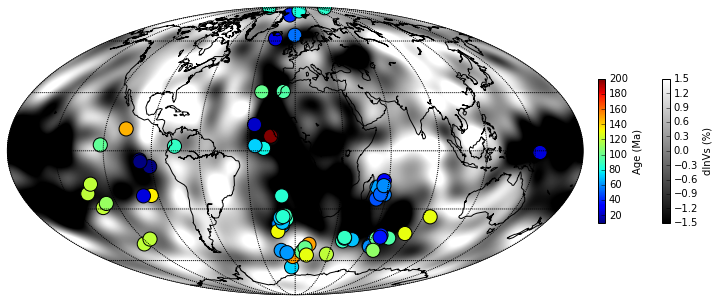

In [20]:
from mpl_toolkits.basemap import Basemap

# load the model data; extract the lon, lat, and dlnVs columns
tmp = np.loadtxt('Data/out2800.dat')
lon = tmp[:,1].reshape((181,361))
lat = tmp[:,2].reshape((181,361))
dvs = tmp[:,3].reshape((181,361))
vmin=-1.5
vmax=1.5
# initialize figure and axes
fig = plt.figure(figsize=(10,5))
ax_map = fig.add_axes([0,0,0.8,1.0])
ax_cbr1 = fig.add_axes([0.82,0.3,0.01,0.4])
ax_cbr2 = fig.add_axes([0.91,0.3,0.01,0.4])
# set up map
m = Basemap(projection='moll', lon_0=0, resolution='c', ax=ax_map)
clip_path = m.drawmapboundary()
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))
# plot the model
s = m.transform_scalar(dvs, lon[0,:], lat[:,0], 1000, 500)
im = m.imshow(s, cmap=plt.cm.gray, clip_path=clip_path, vmin=vmin, vmax=vmax)
# plot the reconstructed LIP centroids
x, y = m(Xr, Yr)
c1 = m.scatter(x, y, c=Age, s=200)
# add colorbars for LIP Age and seismic velocity
cb1 = plt.colorbar(c1, cax=ax_cbr1)
cb1.set_label('Age (Ma)')
cb2 = plt.colorbar(im, cax=ax_cbr2)
cb2.set_label('dlnVs (%)')
# done
plt.show()

### Mid-Ocean Ridge Migration

The same type of analysis can be applied to examine the migration of mid-ocean ridges through time. To do this, we iterate through each isochron in the isochron file, and reconstruct it back to the time corresponding to that chron - the time when the line geometry defines an active mid ocean ridge.

In [21]:
IsochronFile = 'Data/Seton_etal_ESR2012_Isochrons_2012.1.gpmlz'
features = pygplates.FeatureCollection(IsochronFile)

reconstructed_isochron_array = []
isochron_ages = []

for feature in features:

    plateid = feature.get_reconstruction_plate_id()
    conj_plateid = feature.get_conjugate_plate_id()
    Age = feature.get_valid_time()[0]

    # Get the location of the stage rotation that defines the relative motion between the two plates corresponding to
    # the current isochron - in the frame of reference of the plate that the isochron lies on
    finite_rotation = rotation_model.get_rotation(Age, plateid)
    
    # Reconstruct each observation data point back to 0Ma relative to proposed Africa location
    # Convert data lat lon to point on sphere
    feature_geometry = feature.get_geometry()
    reconstructed_geometry = finite_rotation * feature_geometry
    tmp = reconstructed_geometry.to_lat_lon_array()
    reconstructed_isochron_array.append(tmp)
    isochron_ages.append(Age)


The next cell makes a quick and dirty plot, with the colour mapped to age

Note the next section requires the mpltools add-on for matplotlib:
http://tonysyu.github.io/mpltools/index.html

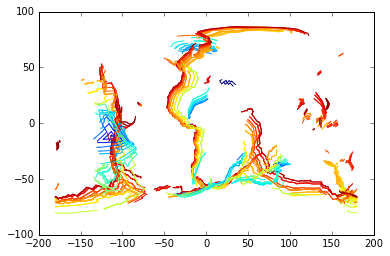

In [29]:
from mpltools import color

AgeMax = 200
for isochron,age in zip(reconstructed_isochron_array,isochron_ages):
    color = plt.cm.jet_r(age/AgeMax)
    plt.plot(isochron[:,1],isochron[:,0],color=color)
plt.show()
    

The next section provides and illustration of what code to use to wrap reconstructed features to the dateline - so that the plot is not so ugly 

In [30]:
IsochronFile = 'Data/Seton_etal_ESR2012_Isochrons_2012.1.gpmlz'
features = pygplates.FeatureCollection(IsochronFile)

reconstructed_isochron_array = []
isochron_ages = []

for feature in features:

    plateid = feature.get_reconstruction_plate_id()
    conj_plateid = feature.get_conjugate_plate_id()
    Age = feature.get_valid_time()[0]

    # Get the location of the stage rotation that defines the relative motion between the two plates corresponding to
    # the current isochron - in the frame of reference of the plate that the isochron lies on
    finite_rotation = rotation_model.get_rotation(Age, int(plateid))
    #print finite_rotation

    # Reconstruct each observation data point back to 0Ma relative to proposed Africa location
    # Convert data lat lon to point on sphere
    feature_geometry = feature.get_geometry()
    reconstructed_geometry = finite_rotation * feature_geometry
    # To wrap features to the dateline, we first need to create a wrapper
    # Then apply this to the geometry
    wrapper = pygplates.DateLineWrapper(0.)
    split_geometry = wrapper.wrap(reconstructed_geometry)
    for geometry in split_geometry:
        X=[]
        Y=[]
        for point in geometry.get_points():
            X.append(point.get_longitude()),Y.append(point.get_latitude())
        reconstructed_isochron_array.append(np.vstack((Y,X)).T)
        isochron_ages.append(Age)


Using Basemap, we can plot the reconstructed ridges over the same image used before to show the deep Earth seismic velocity structure.

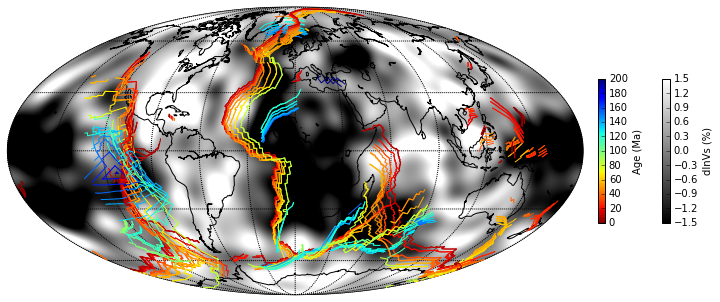

In [41]:
import matplotlib as mpl

# load the model data; extract the lon, lat, and dlnVs columns
tmp = np.loadtxt('Data/out2800.dat')
lon = tmp[:,1].reshape((181,361))
lat = tmp[:,2].reshape((181,361))
dvs = tmp[:,3].reshape((181,361))
vmin=-1.5
vmax=1.5
# initialize figure and axes
fig = plt.figure(figsize=(10,5))
ax_map = fig.add_axes([0,0,0.8,1.0])
ax_cbr1 = fig.add_axes([0.82,0.3,0.01,0.4])
ax_cbr2 = fig.add_axes([0.91,0.3,0.01,0.4])
# set up map
m = Basemap(projection='moll', lon_0=0, resolution='c', ax=ax_map)
clip_path = m.drawmapboundary()
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))
# plot the model
s = m.transform_scalar(dvs, lon[0,:], lat[:,0], 1000, 500)
im = m.imshow(s, cmap=plt.cm.gray, clip_path=clip_path, vmin=vmin, vmax=vmax)
# add reconstructed isochrons
for isochron,age in zip(reconstructed_isochron_array,isochron_ages):
    color = plt.cm.jet_r(age/AgeMax)
    x, y = m(isochron[:,1],isochron[:,0])
    m.plot(x,y,color=color)
# add colorbars for LIP Age and seismic velocity
norm = mpl.colors.Normalize(vmin=0, vmax=AgeMax)
cb1 = mpl.colorbar.ColorbarBase(ax_cbr1, cmap=plt.cm.jet_r,
                                   norm=norm)
cb1.set_label('Age (Ma)')
cb2 = plt.colorbar(im, cax=ax_cbr2)
cb2.set_label('dlnVs (%)')
# done
plt.show()